In [23]:
import os
import pandas as pd
from pathlib import Path
import numpy as np

In [25]:
proj_dir="/master/nplatt/schisto_aim_panel"
results_dir=f"{proj_dir}/results"

In [26]:
info_df=pd.read_csv(f"{proj_dir}/data/platt_et_al_2025_stable1.csv", sep=",", header=0)
info_df.head()

,Library ID,Museum Accession Number (NHM) or Donor ID,Predicted Species,Mitchondrial Haplotype,Population Assignment,NCBI SRA Accession,Project Citation,Country,Locality,Latitude,...,Original life-cycle stage collected,Life-cycle stage sequenced,Num Read Pairs (1e6),Coverage,Final SNV Dataset,Discordant COX1/ITS,% S. haematobium ancestry (q),Origin,Project (Collector),Comments
0,angola_cota_57,MCF03050E0612,S. haematobium,S. haematobium,S. haematobium (southern),SRR11907442,Herein,Angola,Source of the Cota river,-9.26186,...,cercariae,cercariae,76.6,32.96,True,NaN,100.00%,SCAN,Angola malacology survey 2013- NNTDCP/CIS and ...,NaN
1,angola_cota_58,MCF03050E0613,S. haematobium,S. haematobium,S. haematobium (southern),SRR11907441,Herein,Angola,Source of the Cota river,-9.26186,...,cercariae,cercariae,71.6,32.83,True,NaN,100.00%,SCAN,Angola malacology survey 2013- NNTDCP/CIS and ...,NaN
2,angola_cota_59,MCF03050E0614,S. haematobium,S. haematobium,S. haematobium (southern),SRR11907440,Herein,Angola,Source of the Cota river,-9.26186,...,cercariae,cercariae,66.5,25.61,True,NaN,100.00%,SCAN,Angola malacology survey 2013- NNTDCP/CIS and ...,NaN
3,angola_icau_60,MCF03050E0615,S. haematobium,S. haematobium,S. haematobium (southern),SRR11907439,Herein,Angola,Icau Wando village,-8.6451,...,miracidia,miracidia,56.7,25.73,True,NaN,100.00%,SCAN,Angola malacology survey 2013- NNTDCP/CIS and ...,NaN
4,angola_icau_61,MCF03050E0615,S. haematobium,S. haematobium,S. haematobium (southern),SRR11907438,Herein,Angola,Icau Wando village,-8.6451,...,miracidia,miracidia,75.3,30.40,True,NaN,100.00%,SCAN,Angola malacology survey 2013- NNTDCP/CIS and ...,NaN


# Prep Raw Data

In [5]:
os.chdir(f"{proj_dir}/data")

In [6]:
!cp ~/sch_hae_scan/results/filter_genotypes/scan_snvs.vcf.gz* .

## Filter the VCF file

In [7]:
Path(f"{results_dir}/prep_vcf").mkdir(parents=True, exist_ok=True)
os.chdir(f"{results_dir}/prep_vcf")

In [8]:
#which samples to exclude
info_df.loc[info_df["Final SNV Dataset"] == True]["Library ID"].to_csv("samples.include.list", sep=",", header=False, index=False)
!cat samples.include.list | wc -l

163


In [9]:
%%bash

conda run -n popgen --cwd . --live-stream\
    vcftools \
        --gzvcf ../../data/scan_snvs.vcf.gz \
        --maf 0.05 \
        --chr NC_067196.1 \
        --chr NC_067197.1 \
        --chr NC_067198.1 \
        --chr NC_067199.1 \
        --chr NC_067200.1 \
        --chr NC_067201.1 \
        --chr NC_067202.1 \
        --keep samples.include.list \
        --recode \
        --recode-INFO-all \
        --stdout \
        >autosomes_maf05.vcf


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
/../data/scan_snvs.vcf.gz
	--chr NC_067196.1
	--chr NC_067197.1
	--chr NC_067198.1
1--chr NC_067199.
	--chr NC_067200.1
	--chr NC_067201.1
	--chr NC_067202.1
	--keep samples.include.list
FO-allode-IN
	--maf 0.05
	--recode
	--stdout

Using zlib version: 1.3.1
ted at least 2 parts in FORMAT entry: ID=PID,Number=1,Type=String,Description="Physical phasing ID information, where each unique ID within a given sample (but not across samples) connects records within a phasing group">
r,Description="Normalized, Phred-scaled likelihoods for genotypes as defined in the VCF specification">
conditional reference genotype confidence, encoded as a phred quality -10*log10 p(genotype call is wrong)">
llele count in genotypes, for each ALT allele, in the same order as listed">r,Description="A
ast 2 parts in INFO entry: ID=AC,Number=A,Type=Integer,Description="Allele count in genotypes, for each ALT allele, in the sa

In [10]:
%%bash

conda run -n popgen --live-stream \
    plink2 \
        --vcf autosomes_maf05.vcf \
        --allow-extra-chr \
        --double-id \
        --indep-pairwise 25 5 0.20 \
        --out ld

PLINK v2.00a5.12LM 64-bit Intel (25 Jun 2024)  www.cog-genomics.org/plink/2.0/
urcell, Christopher Chang   GNU General Public License v3
Logging to ld.log.
Options in effect:
allow-extra-chr
  --double-id
  --indep-pairwise 25 5 0.20
  --out ld
  --vcf autosomes_maf05.vcf

tart time: Thu Mar  6 17:53:57 2025
iB for main RAM detected, ~1017340 available; reserving 515643 M
workspace.
Using up to 192 threads (change this with --threads).
--vcf: 5972982 variants scanned.
--vcf: ld-temporary.pgen + ld-temporary.pvar.zst + ld-temporary.psam written.
s, 0 males, 163 ambiguous; 163 founders) loaded from
ld-temporary.psam.
 ld-temporary.pvar.zst. from
Note: No phenotype data present.
done.lating allele frequencies... 0%
5591481/5972982 variants removed.ds): 0%
Variant lists written to ld.prune.in and ld.prune.out .
End time: Thu Mar  6 17:54:58 2025


In [ ]:
%%bash

conda run -n vcftools --live-stream \
    vcftools \
        --vcf autosomes_maf05.vcf \
        --exclude ld.prune.out \
        --recode \
        --recode-INFO-all \
        --stdout \
        >scan_autosomes_maf05_ld.vcf

echo "snv_id" >all_snvs.list; grep -v "#" scan_autosomes_maf05_ld.vcf | cut -f3 >>all_snvs.list

# PCA

In [180]:
Path(f"{results_dir}/pca").mkdir(parents=True, exist_ok=True)
os.chdir(f"{results_dir}/pca")

In [14]:
%%bash
conda run -n popgen --cwd . --live-stream\
    plink2 \
        --threads 12 \
        --vcf ../prep_vcf/scan_autosomes_maf05_ld.vcf \
        --pca 10 allele-wts \
        --double-id \
        --allow-extra-chr \
        --out pca

PLINK v2.00a5.12LM 64-bit Intel (25 Jun 2024)  www.cog-genomics.org/plink/2.0/
urcell, Christopher Chang   GNU General Public License v3
Logging to pca.log.
Options in effect:
-allow-extra-chr
  --double-id
  --out pca
  --pca 10 allele-wts
  --threads 12
scan_autosomes_maf05_ld.vcf

Start time: Thu Mar  6 17:58:34 2025
 available; reserving 515643 MiB for main
workspace.
ads). up to 12 threads (change this with --thre
--vcf: 381501 variants scanned.
--vcf: pca-temporary.pgen + pca-temporary.pvar.zst + pca-temporary.psam
written.
ales, 0 males, 163 ambiguous; 163 founders) loaded from
pca-temporary.psam.
rom pca-temporary.pvar.zst.
Note: No phenotype data present.
done.lating allele frequencies... 0%
done.ructing GRM: 0%
done.cting for missingness... 0%
done.cting eigenvalues and eigenvectors... 
--pca: Allele weights written to pca.eigenvec.allele .
nvec , and eigenvalues written toa.eige
pca.eigenval .
End time: Thu Mar  6 17:58:41 2025


In [15]:
#get eigen values and sample labels
pca_df=pd.read_csv("pca.eigenvec", sep="\t", header=0)
pca_df=pca_df.drop("#FID", axis=1)

#merge the dataframes
pca_df=pca_df.merge(info_df, how='left', left_on="IID", right_on='Library ID')

#fix the country which contains some float NaNs
pca_df["country"] = pca_df["Country"].astype(str)

countries = sorted(pca_df["country"].unique().astype(str))
pca_df.to_csv("pca_df.csv", sep=",", header=True, index=False)
pca_df


,IID,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,Life-cycle stage sequenced,Num Read Pairs (1e6),Coverage,Final SNV Dataset,Discordant COX1/ITS,% S. haematobium ancestry (q),Origin,Project (Collector),Comments,country
0,NG_au_1.2,-0.193788,0.034904,-0.000030,0.007716,0.004214,-0.001483,-0.003820,-0.014784,-0.056267,...,adult worm (natural),55.6,20.53,True,NaN,0.00%,Texas Biomedical Research Institute,TxBiomed Nigeria 2019 (Egie Elisha Enabulele),Adult worms were collected directly from cattl...,Nigeria
1,NG_au_2.10,-0.192712,0.034114,-0.000016,0.008737,0.004191,0.000039,-0.004853,-0.012376,-0.063461,...,adult worm (natural),52.1,23.15,True,NaN,0.00%,Texas Biomedical Research Institute,TxBiomed Nigeria 2019 (Egie Elisha Enabulele),Adult worms were collected directly from cattl...,Nigeria
2,NG_au_2.13,-0.193488,0.034479,-0.000407,0.005152,0.004661,0.001240,-0.006628,-0.013438,-0.061754,...,adult worm (natural),53.0,23.30,True,NaN,0.00%,Texas Biomedical Research Institute,TxBiomed Nigeria 2019 (Egie Elisha Enabulele),Adult worms were collected directly from cattl...,Nigeria
3,NG_au_2.5,-0.192770,0.034375,0.001173,0.001757,0.005212,0.001661,-0.002561,-0.005953,-0.057693,...,adult worm (natural),58.1,24.73,True,NaN,0.00%,Texas Biomedical Research Institute,TxBiomed Nigeria 2019 (Egie Elisha Enabulele),Adult worms were collected directly from cattl...,Nigeria
4,NG_au_2.6,-0.191722,0.034577,-0.000658,0.008808,0.005192,0.000453,-0.003978,-0.019422,-0.066838,...,adult worm (natural),62.6,27.05,True,NaN,0.00%,Texas Biomedical Research Institute,TxBiomed Nigeria 2019 (Egie Elisha Enabulele),Adult worms were collected directly from cattl...,Nigeria
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158,niger_libore_166,0.019183,-0.080569,-0.019166,-0.068836,0.015894,-0.087431,-0.030895,-0.041804,-0.014130,...,cercariae,81.6,41.80,True,NaN,96.11%,SCAN,SCORE Niger non-SCORE site,NaN,Niger
159,niger_libore_167,0.020423,-0.080046,-0.008740,-0.064435,0.025870,-0.069314,-0.002363,-0.010881,-0.027030,...,cercariae,63.2,31.23,True,NaN,95.97%,SCAN,SCORE Niger non-SCORE site,NaN,Niger
160,niger_libore_168,0.018833,-0.078780,-0.017340,-0.061889,0.005610,-0.040905,0.000884,-0.060515,-0.057258,...,cercariae,72.4,39.19,True,NaN,95.78%,SCAN,SCORE Niger non-SCORE site,NaN,Niger
161,niger_libore_169,0.020519,-0.074870,-0.018572,-0.053636,0.014773,-0.056789,0.007042,-0.014465,-0.054662,...,cercariae,95.9,50.42,True,NaN,95.79%,SCAN,SCORE Niger non-SCORE site,NaN,Niger


In [61]:
load_df = pd.read_csv("pca.eigenvec.allele", sep="\t", header=0)
load_df

,#CHROM,ID,REF,ALT,A1,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,NC_067196.1,NC_067196.1:124178,G,A,G,0.006183,-0.357448,-0.361962,-0.660223,0.133347,-1.017570,-0.234786,-0.792458,-0.378462,0.653776
1,NC_067196.1,NC_067196.1:124178,G,A,A,-0.006183,0.357448,0.361962,0.660223,-0.133347,1.017570,0.234786,0.792458,0.378462,-0.653776
2,NC_067196.1,NC_067196.1:124348,T,C,T,0.722871,-0.075344,-0.010245,0.137878,0.043088,-0.400753,-0.020437,-0.195817,-0.077878,-0.013758
3,NC_067196.1,NC_067196.1:124348,T,C,C,-0.722871,0.075344,0.010245,-0.137878,-0.043088,0.400753,0.020437,0.195817,0.077878,0.013758
4,NC_067196.1,NC_067196.1:147062,C,T,C,0.011960,0.165288,-0.739370,-0.498169,-0.579757,-0.129999,-0.159289,-0.211183,-0.521566,-0.245383
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
762997,NC_067202.1,NC_067202.1:19478217,C,T,T,0.171237,-0.153556,0.569210,0.232004,-0.624436,-0.035646,-0.263980,0.095318,0.383560,-0.269444
762998,NC_067202.1,NC_067202.1:19478231,C,A,C,0.121050,0.553264,-1.028450,-0.275237,-1.067260,0.137823,0.077264,0.008584,-0.163184,0.673963
762999,NC_067202.1,NC_067202.1:19478231,C,A,A,-0.121050,-0.553264,1.028450,0.275237,1.067260,-0.137823,-0.077264,-0.008584,0.163184,-0.673963
763000,NC_067202.1,NC_067202.1:19478762,C,G,C,0.112333,0.645555,-0.255612,-0.166213,0.965373,0.572820,-0.042035,0.121385,0.374986,-0.301796


In [222]:
max_pcs = 2
n_snvs_per_pc = 3000

%env MAX_PCS=$max_pcs
%env N_SNVS=$n_snvs_per_pc

# Dictionary to store top variants for each PC
top_variants_per_pc = {}

# Iterate over the first six PCs
for i in range(1, max_pcs + 1):  # Assuming PCs start from column index 1
    pc_name = f"PC{i}"  # Get column name for reference
    top_variants_per_pc[pc_name] = load_df.nlargest(n_snvs_per_pc, pc_name)

# Combine all selected variants into a single DataFrame
top_variants_all_pcs = pd.concat(top_variants_per_pc.values()).drop_duplicates()

top_variants_all_pcs.to_csv(f"top_variants_pc1-{max_pcs}_n{n_snvs_per_pc}.csv", sep=",", header=True, index=False)
top_variants_all_pcs["ID"].to_csv(f"top_variants_pc1-{max_pcs}_n{n_snvs_per_pc}.list", sep=",", header=True, index=False)
top_variants_all_pcs

env: MAX_PCS=2
env: N_SNVS=3000


,#CHROM,ID,REF,ALT,A1,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
369327,NC_067198.1,NC_067198.1:12006234,T,C,C,1.048470,-0.344782,-0.013033,0.064940,-0.019233,-0.029859,-0.082414,-0.090633,-0.034923,0.011968
263265,NC_067197.1,NC_067197.1:23785770,T,A,A,1.047020,-0.343836,-0.014058,0.048204,-0.011810,-0.034988,-0.194489,-0.148372,-0.059154,0.034145
729413,NC_067202.1,NC_067202.1:6563502,A,G,G,1.047020,-0.343836,-0.014058,0.048204,-0.011810,-0.034988,-0.194489,-0.148372,-0.059154,0.034145
142133,NC_067196.1,NC_067196.1:65368267,A,G,G,1.046700,-0.344433,-0.019021,0.079592,-0.013006,-0.054821,-0.116214,-0.169286,-0.062405,0.020334
744313,NC_067202.1,NC_067202.1:14983871,T,C,C,1.046010,-0.352646,-0.025618,0.069289,-0.045544,-0.020700,-0.124247,-0.175318,-0.053519,0.043498
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89146,NC_067196.1,NC_067196.1:38087580,A,T,A,-0.206952,1.163760,0.209474,-0.032276,0.028132,0.513663,-0.139856,0.356759,0.247928,0.072513
497304,NC_067199.1,NC_067199.1:23119341,G,A,G,-0.194778,1.163720,0.323816,0.021521,-0.368629,-0.247558,1.117360,-0.065138,-0.365579,-0.235303
91533,NC_067196.1,NC_067196.1:38975038,A,G,G,0.397739,1.163680,-0.489511,-0.288200,-0.086228,0.760624,-0.057220,-0.038813,0.139750,0.142089
465983,NC_067199.1,NC_067199.1:8295266,C,T,T,-0.171441,1.163670,0.223595,0.623368,-0.547318,0.519761,-0.468352,0.207491,-0.425048,0.190756


In [223]:
%%bash

conda run -n popgen --cwd . --live-stream\
    vcftools \
        --vcf ../prep_vcf/scan_autosomes_maf05_ld.vcf \
        --snps top_variants_pc1-${MAX_PCS}_n${N_SNVS}.list \
        --recode \
        --recode-INFO-all \
        --stdout \
        >top_variants_pc1-${MAX_PCS}_n${N_SNVS}.vcf


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
rep_vcf/scan_autosomes_maf05_ld.vcf
	--recode-INFO-all
	--recode
st-snps top_variants_pc1-2_n3000.li
	--stdout

ted at least 2 parts in FORMAT entry: ID=PID,Number=1,Type=String,Description="Physical phasing ID information, where each unique ID within a given sample (but not across samples) connects records within a phasing group">
r,Description="Normalized, Phred-scaled likelihoods for genotypes as defined in the VCF specification">
conditional reference genotype confidence, encoded as a phred quality -10*log10 p(genotype call is wrong)">
llele count in genotypes, for each ALT allele, in the same order as listed">r,Description="A
ast 2 parts in INFO entry: ID=AC,Number=A,Type=Integer,Description="Allele count in genotypes, for each ALT allele, in the same order as listed">
F,Number=A,Type=Float,Description="Allele Frequency, for each ALT allele, in the same order as listed">
Frequency, for each AL

In [224]:
%%bash

conda run -n popgen --cwd . --live-stream\
    plink2 \
        --threads 12 \
        --vcf top_variants_pc1-${MAX_PCS}_n${N_SNVS}.vcf \
        --pca 10 \
        --double-id \
        --allow-extra-chr \
        --out pca.top_variants_pc1-${MAX_PCS}_n${N_SNVS}

PLINK v2.00a5.12LM 64-bit Intel (25 Jun 2024)  www.cog-genomics.org/plink/2.0/
urcell, Christopher Chang   GNU General Public License v3
g.gging to pca.top_variants_pc1-2_n3000.lo
Options in effect:
  --allow-extra-chr
  --double-id
  --out pca.top_variants_pc1-2_n3000
 10-pca
  --threads 12
  --vcf top_variants_pc1-2_n3000.vcf

Start time: Fri Mar  7 16:04:42 2025
7 MiB RAM detected, ~1017659 available; reserving 515643 MiB for main
workspace.
ads (change this with --threads).
--vcf: 6000 variants scanned.
--vcf: pca.top_variants_pc1-2_n3000-temporary.pgen +
t +.top_variants_pc1-2_n3000-temporary.pvar.zs
pca.top_variants_pc1-2_n3000-temporary.psam written.
ous; 163 founders) loaded froms, 163 ambigu
pca.top_variants_pc1-2_n3000-temporary.psam.
m pca.top_variants_pc1-2_n3000-temporary.pvar.zst.
Note: No phenotype data present.
le frequencies... done.
done.
done.
done.cting eigenvalues and eigenvectors... 
--pca: Eigenvectors written to pca.top_variants_pc1-2_n3000.eigenvec , and
 to pc

In [225]:
#get eigen values and sample labels
pca_top_pcs_df=pd.read_csv(f"pca.top_variants_pc1-{max_pcs}_n{n_snvs_per_pc}.eigenvec", sep="\t", header=0)
pca_top_pcs_df=pca_top_pcs_df.drop("#FID", axis=1)

#merge the dataframes
pca_top_pcs_df=pca_top_pcs_df.merge(info_df, how='left', left_on="IID", right_on='Library ID')
pca_top_pcs_df.to_csv(f"pca.top_variants_pc1-{max_pcs}_n{n_snvs_per_pc}.df.csv", sep=",", header=True, index=False)
# pca_top_pcs_df


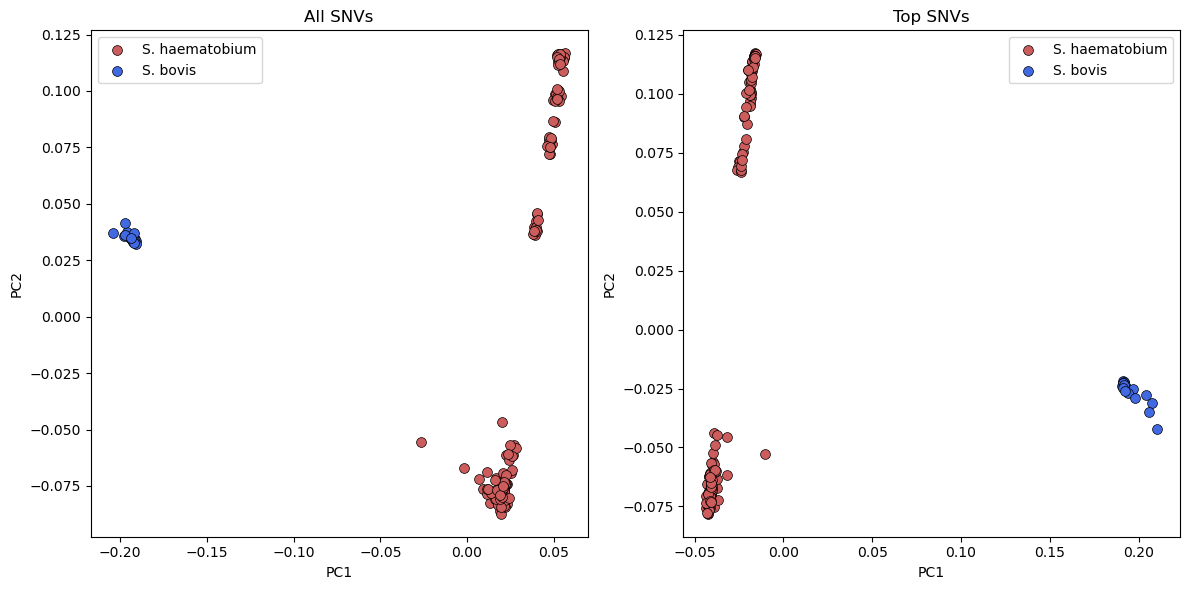

In [226]:
import matplotlib.pyplot as plt
import yaml
import pandas as pd

# Define directories
proj_dir = "/master/nplatt/schisto_aim_panel"
results_dir = f"{proj_dir}/results"

# Load data
info_df = pd.read_csv(f"{proj_dir}/data/platt_et_al_2025_stable1.csv", sep=",")
all_snvs_df = pd.read_csv(f"{results_dir}/pca/pca_df.csv", sep=",")
top_snvs_df = pd.read_csv(f"{results_dir}/pca/pca.top_variants_pc1-{max_pcs}_n{n_snvs_per_pc}.df.csv", sep=",")

# Filter for specific species
all_snvs_df = all_snvs_df[all_snvs_df["Predicted Species"].isin(["S. haematobium", "S. bovis"])]
top_snvs_df = top_snvs_df[top_snvs_df["Predicted Species"].isin(["S. haematobium", "S. bovis"])]

# Load YAML config
with open(f"{proj_dir}/code/plotting_config.yaml", "r") as config_file:
    config = yaml.safe_load(config_file)

# Create figure with two subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Subplot 1: All SNVs
for species in ["S. haematobium", "S. bovis"]:
    all_snv_data = all_snvs_df[all_snvs_df["Predicted Species"] == species]
    axes[0].scatter(
        all_snv_data["PC1"],
        all_snv_data["PC2"],
        color=config["species"][species]["color"],
        edgecolor="black",
        s=50,
        linewidths=0.5,
        label=species
    )
axes[0].set_xlabel("PC1")
axes[0].set_ylabel("PC2")
axes[0].set_title("All SNVs")
axes[0].legend()

# Subplot 2: Top SNVs
for species in ["S. haematobium", "S. bovis"]:
    top_snv_data = top_snvs_df[top_snvs_df["Predicted Species"] == species]
    axes[1].scatter(
        top_snv_data["PC1"],
        top_snv_data["PC2"],
        color=config["species"][species]["color"],
        edgecolor="black",
        s=50,
        linewidths=0.5,
        label=species
    )
axes[1].set_xlabel("PC1")
axes[1].set_ylabel("PC2")
axes[1].set_title("Top SNVs")
axes[1].legend()

# Adjust layout
plt.tight_layout()

# Save the figure
plt.savefig(f"pca_comparison_pc1-{max_pcs}_n{n_snvs_per_pc}.png", facecolor="white", dpi=600, bbox_inches="tight")
plt.savefig(f"pca_comparison_pc1-{max_pcs}_n{n_snvs_per_pc}.svg")

# Show plot
plt.show()

# SubSample variants

In [247]:
Path(f"{results_dir}/subsample_top_snvs").mkdir(parents=True, exist_ok=True)
os.chdir(f"{results_dir}/subsample_top_snvs")

## Subsample from all MAF05 LD variants

In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from scipy.spatial import procrustes

# Set environment variables
proj_dir="/master/nplatt/schisto_aim_panel"
results_dir=f"{proj_dir}/results"
os.chdir(f"{results_dir}/subsample_top_snvs")
max_pcs = 2
n_snvs_per_pc = 3000
all_snvs_df = pd.read_csv(f"{results_dir}/pca/pca_df.csv", sep=",")
procrustes_distances=[]
pca_df = pd.read_csv(f"{results_dir}/pca/top_variants_pc1-{max_pcs}_n{n_snvs_per_pc}.list", sep=",", header=0)

# Create target dataframe
target_df = pd.read_csv(f"{results_dir}/prep_vcf/all_snvs.list", sep=",", header=0)

# Loop through different sample sizes and replicates
for n_snvs in list(range(500, 1, -10)):
    print(n_snvs)
    for replicate in range(100):
        # Set a unique random seed per replicate for consistency
        random_seed = np.random.randint(0, 99999)

        # Sample SNVs
        sampled_snvs = target_df["snv_id"].sample(n=n_snvs, random_state=random_seed)
        
        # Save the sampled SNVs to a file
        sample_file = f"all.subsample_n{n_snvs}_rep{replicate}.list"
        sampled_snvs.to_csv(sample_file, sep=",", header=False, index=False)

        # Define VCF file names
        input_vcf = f"{results_dir}/prep_vcf/scan_autosomes_maf05_ld.vcf"
        output_plink=f"all.subsample_n{n_snvs}_rep{replicate}"
        output_vcf = f"all.subsample_n{n_snvs}_rep{replicate}.vcf"
        vcftools_log = f"all.subsample_n_n{n_snvs}_rep{replicate}.vcftools.log"
        plink2_log = f"all.subsample_n_n{n_snvs}_rep{replicate}.plink2.log"
        png=f"all.subsample_n{n_snvs}_rep{replicate}.pca.png"
        svg=f"all.subsample_n{n_snvs}_rep{replicate}.pca.svg"
        eigenvec=f"all.subsample_n{n_snvs}_rep{replicate}.eigenvec"

         # Run VCFTOOLS and log output
        os.system(f"""
        conda run -n popgen --cwd . --live-stream \
            vcftools \
                --vcf {input_vcf} \
                --snps {sample_file} \
                --recode \
                --recode-INFO-all \
                --stdout > {output_vcf} 2> {vcftools_log}
        """)
        
        # Run PLINK2 for PCA and log output
        os.system(f"""
        conda run -n popgen --cwd . --live-stream \
            plink2 \
                --threads 12 \
                --vcf {output_vcf} \
                --pca 10 \
                --double-id \
                --allow-extra-chr \
                --out {output_plink} \
            > {plink2_log} 2>&1
        """)

        target_snvs_df = pd.read_csv(eigenvec, sep="\t", header=0)
        
        # Extract PC1 and PC2 coordinates from your dataframes
        X = all_snvs_df[["PC1", "PC2"]].to_numpy()
        Y = target_snvs_df[["PC1", "PC2"]].to_numpy()
        
        # Ensure both datasets have the same number of points
        if X.shape != Y.shape:
            raise ValueError(f"Shapes of X {X.shape} and Y {Y.shape} must be the same for Procrustes analysis.")
        
        # Perform Procrustes analysis
        m1, m2, disparity = procrustes(X, Y)
        
        # Print the Procrustes distance
        # print(f"Procrustes Distance (Disparity): {disparity}")
        procrustes_distances.append([n_snvs, replicate, disparity])
        
        # Plot the original scatter plots
        fig, axs = plt.subplots(1, 2, figsize=(12, 5))
        
        # Original Scatter Plots
        axs[0].scatter(X[:, 0], X[:, 1], label=f"WG", color='blue', alpha=0.5, edgecolor="black", linewidth=0.5)
        axs[0].scatter(Y[:, 0], Y[:, 1], label=f"Sub", color='red', alpha=0.5, edgecolor="black", linewidth=0.5)
        axs[0].set_title("Original Scatter Plots")
        axs[0].legend()
        
        # Aligned Scatter Plots after Procrustes transformation
        axs[1].scatter(m1[:, 0], m1[:, 1], label=f"WG", color='blue', alpha=0.5, edgecolor="black", linewidth=0.5)
        axs[1].scatter(m2[:, 0], m2[:, 1], label=f"Sub", color='red', alpha=0.5, edgecolor="black", linewidth=0.5)
        axs[1].set_title("Procrustes Aligned Scatter Plots")
        axs[1].legend()
        
        # Save the figure
        plt.savefig(png, facecolor="white", dpi=600, bbox_inches="tight")
        plt.savefig(svg)
        plt.close()
        
# Convert results to a DataFrame and save
procrustes_df = pd.DataFrame(procrustes_distances, columns=["n_snvs", "replicate", "procrustes_distance"])
procrustes_df.to_csv("all.procrustes_distances.csv", index=False)


500


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a boxplot grouped by 'n_snvs' using 'procrustes_distance' as values
plt.figure(figsize=(8, 6))
sns.boxplot(x="n_snvs", y="procrustes_distance", data=procrustes_df)

# Set labels and title
plt.xlabel("Number of SNVs", fontsize=12)
plt.ylabel("Procrustes Distance", fontsize=12)
plt.title("Boxplot of Procrustes Distance by Number of SNVs", fontsize=14)

# Show the plot
plt.show()


## Subsample from MAF05 LD PCA informative variants

In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from scipy.spatial import procrustes

# Set environment variables
proj_dir="/master/nplatt/schisto_aim_panel"
results_dir=f"{proj_dir}/results"
os.chdir(f"{results_dir}/subsample_top_snvs")
max_pcs = 2
n_snvs_per_pc = 3000
all_snvs_df = pd.read_csv(f"{results_dir}/pca/pca_df.csv", sep=",")
procrustes_distances=[]
pca_df = pd.read_csv(f"{results_dir}/pca/top_variants_pc1-{max_pcs}_n{n_snvs_per_pc}.list", sep=",", header=0)

# Create target dataframe
target_df = pd.read_csv(f"{results_dir}/pca/top_variants_pc1-{max_pcs}_n{n_snvs_per_pc}.list", sep=",", header=0)
target_df = target_df.rename({"ID": "snv_id"}, axis=1)

# Loop through different sample sizes and replicates
for n_snvs in list(range(500, 1, -10)):
    print(n_snvs)
    for replicate in range(100):
        # Set a unique random seed per replicate for consistency
        random_seed = np.random.randint(0, 99999)

        # Sample SNVs
        sampled_snvs = target_df["snv_id"].sample(n=n_snvs, random_state=random_seed)
        
        # Save the sampled SNVs to a file
        sample_file = f"inf.subsample_n{n_snvs}_rep{replicate}.list"
        sampled_snvs.to_csv(sample_file, sep=",", header=False, index=False)

        # Define VCF file names
        input_vcf = f"{results_dir}/prep_vcf/scan_autosomes_maf05_ld.vcf"
        output_plink=f"inf.subsample_n{n_snvs}_rep{replicate}"
        output_vcf = f"inf.subsample_n{n_snvs}_rep{replicate}.vcf"
        vcftools_log = f"inf.subsample_n_n{n_snvs}_rep{replicate}.vcftools.log"
        plink2_log = f"inf.subsample_n_n{n_snvs}_rep{replicate}.plink2.log"
        png=f"inf.subsample_n{n_snvs}_rep{replicate}.pca.png"
        svg=f"inf.subsample_n{n_snvs}_rep{replicate}.pca.svg"
        eigenvec=f"inf.subsample_n{n_snvs}_rep{replicate}.eigenvec"

         # Run VCFTOOLS and log output
        os.system(f"""
        conda run -n popgen --cwd . --live-stream \
            vcftools \
                --vcf {input_vcf} \
                --snps {sample_file} \
                --recode \
                --recode-INFO-all \
                --stdout > {output_vcf} 2> {vcftools_log}
        """)
        
        # Run PLINK2 for PCA and log output
        os.system(f"""
        conda run -n popgen --cwd . --live-stream \
            plink2 \
                --threads 12 \
                --vcf {output_vcf} \
                --pca 10 \
                --double-id \
                --allow-extra-chr \
                --out {output_plink} \
            > {plink2_log} 2>&1
        """)

        target_snvs_df = pd.read_csv(eigenvec, sep="\t", header=0)
        
        # Extract PC1 and PC2 coordinates from your dataframes
        X = all_snvs_df[["PC1", "PC2"]].to_numpy()
        Y = target_snvs_df[["PC1", "PC2"]].to_numpy()
        
        # Ensure both datasets have the same number of points
        if X.shape != Y.shape:
            raise ValueError(f"Shapes of X {X.shape} and Y {Y.shape} must be the same for Procrustes analysis.")
        
        # Perform Procrustes analysis
        m1, m2, disparity = procrustes(X, Y)
        
        # Print the Procrustes distance
        # print(f"Procrustes Distance (Disparity): {disparity}")
        procrustes_distances.append([n_snvs, replicate, disparity])
        
        # Plot the original scatter plots
        fig, axs = plt.subplots(1, 2, figsize=(12, 5))
        
        # Original Scatter Plots
        axs[0].scatter(X[:, 0], X[:, 1], label=f"WG", color='blue', alpha=0.5, edgecolor="black", linewidth=0.5)
        axs[0].scatter(Y[:, 0], Y[:, 1], label=f"Sub", color='red', alpha=0.5, edgecolor="black", linewidth=0.5)
        axs[0].set_title("Original Scatter Plots")
        axs[0].legend()
        
        # Aligned Scatter Plots after Procrustes transformation
        axs[1].scatter(m1[:, 0], m1[:, 1], label=f"WG", color='blue', alpha=0.5, edgecolor="black", linewidth=0.5)
        axs[1].scatter(m2[:, 0], m2[:, 1], label=f"Sub", color='red', alpha=0.5, edgecolor="black", linewidth=0.5)
        axs[1].set_title("Procrustes Aligned Scatter Plots")
        axs[1].legend()
        
        # Save the figure
        plt.savefig(png, facecolor="white", dpi=600, bbox_inches="tight")
        plt.savefig(svg)
        plt.close()
        
# Convert results to a DataFrame and save
procrustes_df = pd.DataFrame(procrustes_distances, columns=["n_snvs", "replicate", "procrustes_distance"])
procrustes_df.to_csv("inf.procrustes_distances.csv", index=False)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a boxplot grouped by 'n_snvs' using 'procrustes_distance' as values
plt.figure(figsize=(8, 6))
sns.boxplot(x="n_snvs", y="procrustes_distance", data=procrustes_df)

# Set labels and title
plt.xlabel("Number of SNVs", fontsize=12)
plt.ylabel("Procrustes Distance", fontsize=12)
plt.title("Boxplot of Procrustes Distance by Number of SNVs", fontsize=14)

# Show the plot
plt.show()
